# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## План работы

   * Откроем файл с данными и изучим его.
   * Разделим исходные данные на обучающую, валидационную и тестовую выборки.
   * Исследуем качество разных моделей, меняя гиперпараметры.
   * Проверим качество выбранной модели на тестовой выборке.
   * Проверим модели на вменяемость.

## Откроем и изучим файл

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

Откроем таблицы и изучим общую информацию.

In [2]:
if os.path.exists('users_behavior.csv'):
    df = pd.read_csv('users_behavior.csv')
else:
    df = pd.read_csv('/datasets/users_behavior.csv')

df.info()
display(df.head())
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Данные по ТЗ уже предобработаны, но можно заменить тип данных в столбцах `calls` и `messages`, т.к. они должны быть по логике содержания целочисленными, а для `is_ultra` понизить разрядность для экономии памяти.

In [3]:
df['calls'] = df['calls'].astype('int16')
df['messages'] = df['messages'].astype('int16')
df['is_ultra'] = df['is_ultra'].astype('int8')

Проверим дубликаты.

In [4]:
df.duplicated().sum()

0

Проверим корреляции в данных.

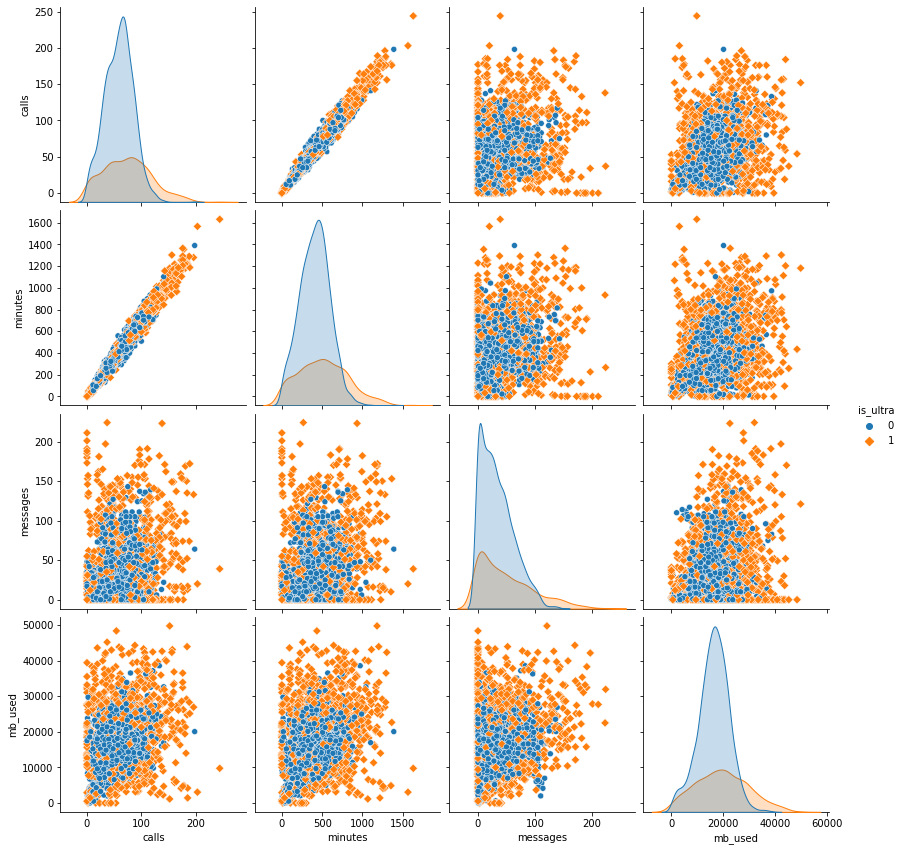

In [5]:
sns.pairplot(df, hue='is_ultra', height=3, markers=['o', 'D'])

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Все пары признаков довольно хорошо коррелируют с тарифом.

На графике зависимости длительности звонков от количества звонков видна сильная линейная зависимость. Чем больше длительность и количество звонков - тем выше вероятность что у абонента тариф ultra и наоборот.

На остальных парах признаков видна общая тенденция к более высоким разбросам по значениям для тарифа ultra.

### Вывод

Данные уже предобработаны. Образцы названы в соответствии с рекомендациями PEP 8. Пропусков и дубликатов в данных нет.

Мы провели частичную замену типов данных, теперь они готовы для обработки.

## Проведём разбиение на выборки

Зададим макропараметры.

In [7]:
# соотношения выборок
train_ratio = .8
validation_ratio = .1
test_ratio = .1

# случайное зерно
seed = 314159

Проведём разделение данных на цель и признаки.

In [8]:
features = df[['calls', 'minutes', 'messages', 'mb_used']]
target = df['is_ultra']

Проведём разделение на выборки.

In [9]:
features_trainval, features_test, target_trainval, target_test = train_test_split(
    features, target,
    test_size=test_ratio,
    random_state=seed,
    stratify=target
)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_trainval, target_trainval,
    test_size=validation_ratio/(1-test_ratio),
    random_state=seed,
    stratify=target_trainval
)

Проверим разделение.

In [10]:
print(f'Доля тренировочного набора: {features_train.shape[0]/features.shape[0]:.2f}\n\
Доля валидационного набора: {features_valid.shape[0]/features.shape[0]:.2f}\n\
Доля тестового набора: {features_test.shape[0]/features.shape[0]:.2f}')

print(f'Доля пользователей тарифа Ultra для тренировочного набора: {target_train.mean():.2f}\n\
Доля пользователей тарифа Ultra для валидационного набора: {target_valid.mean():.2f}\n\
Доля пользователей тарифа Ultra для тестового набора: {target_test.mean():.2f}')

Доля тренировочного набора: 0.80
Доля валидационного набора: 0.10
Доля тестового набора: 0.10
Доля пользователей тарифа Ultra для тренировочного набора: 0.31
Доля пользователей тарифа Ultra для валидационного набора: 0.31
Доля пользователей тарифа Ultra для тестового набора: 0.31


### Вывод

Мы провели разделение исходных данных на целевые показатели и признаки. Перед разделением провели грубую прикидку оптимального соотношения выборок, так точность моделей повышается по мере увеличения тренировочной выборки вплоть до 80%, однако далее результат метрики accuracy на тестовой выборке начинает падать, что говорит о переобучении.

Разделили данные на тренировочную, валидационную и тестовые выборки.

Приступим к исследованию моделей.

## Исследуем модели

Проведём подбор гиперпараметров для трёх моделей.

*грубый подбор гиперпараметров моделей в работе не показан*

### Decision tree

In [11]:
best_model_dt = None
best_accuracy_dt = 0
best_depth_dt = 0
for depth in tqdm(range(1, 16), desc='Progress: '):
    for leaf in range(2,31):
        for sample in range(2,15):
            model = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=leaf, min_samples_split=sample, random_state=seed)
            model.fit(features_train, target_train)
            prediction_valid = model.predict(features_valid)
            accuracy = accuracy_score(target_valid, prediction_valid)
            if accuracy > best_accuracy_dt:
                best_model_dt = model
                best_accuracy_dt = accuracy
                best_depth_dt = depth

Progress: 100%|██████████| 15/15 [00:41<00:00,  2.78s/it]


### Random forest

In [12]:
best_model_rf = None
best_accuracy_rf = 0
best_est_rf = 0
best_depth_rf = 0
for est in tqdm(range(1, 1001, 100), desc='Progress: '):
    for depth in range(1, 15):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=seed, n_jobs=-1)
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, prediction_valid)
        if accuracy > best_accuracy_rf:
            best_model_rf = model
            best_accuracy_rf = accuracy
            best_est_rf = est
            best_depth_rf = depth

Progress: 100%|██████████| 10/10 [03:20<00:00, 20.04s/it]


### Logistic regression

In [13]:
best_model_lr = None
best_accuracy_lr = 0
best_solver_lr = None
for solver in tqdm(['newton-cg', 'lbfgs', 'sag'], desc='Progress: '):
    model = LogisticRegression(random_state=seed,
                               solver=solver,
                               max_iter=10000,
                               n_jobs=-1,
                               warm_start=True
                              )
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, prediction_valid)
    if accuracy > best_accuracy_lr:
        best_model_lr = model
        best_accuracy_lr = accuracy
        best_solver_lr = solver

Progress: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Посмотрим на лучшую точность и гиперпараметры при которых она достигнута.

In [14]:
print(f'Decision tree лучшая точность = {best_accuracy_dt:.2%}, при depth = {best_depth_dt}')
print(f'Random forest лучшая точность = {best_accuracy_rf:.2%}, при depth = {best_depth_dt} и est = {best_est_rf}')
print(f'Logistic regression лучшая точность = {best_accuracy_lr:.2%}, при solver = {best_solver_lr}')

Decision tree лучшая точность = 79.81%, при depth = 7
Random forest лучшая точность = 81.06%, при depth = 7 и est = 101
Logistic regression лучшая точность = 73.91%, при solver = newton-cg


### Вывод

Мы провели обучение на тренировочной выборке на трёх моделях: дереве решений, случайном лесе и логичтисческой регрессии.

Подобрали оптимальные параметры для обучения выбранных моделей.

Лучшую точность на валидационной выборке показала модель случайного леса, точность составила 81.06%

## Проверим модели на тестовой выборке

In [15]:
best_model_dt.fit(features_trainval, target_trainval)
prediction_test_dt = best_model_dt.predict(features_test)
accuracy_test_dt = accuracy_score(target_test, prediction_test_dt)
best_model_rf.fit(features_trainval, target_trainval)
prediction_test_rf = best_model_rf.predict(features_test)
accuracy_test_rf = accuracy_score(target_test, prediction_test_rf)
prediction_test_lr = best_model_lr.predict(features_test)
accuracy_test_lr = accuracy_score(target_test, prediction_test_lr)

print(f'Decision tree лучшая точность на тестовой выборке = {accuracy_test_dt:.2%}')
print(f'Random forest лучшая точность на тестовой выборке = {accuracy_test_rf:.2%}')
print(f'Logistic regression лучшая точность на тестовой выборке = {accuracy_test_lr:.2%}')

Decision tree лучшая точность на тестовой выборке = 79.50%
Random forest лучшая точность на тестовой выборке = 82.30%
Logistic regression лучшая точность на тестовой выборке = 75.16%


### Вывод

Проверка на тестовой выборке всех трёх моделей показала незначительное отклонение метрики accuracy от оценки на валидационной выборке, что говорит об отсутствии пере- или недообучения.

Все три модели показали accuracy не меньше 75%.

Лучшую точность на тестовой выборке показала модель случайного леса, точность составила 82.30%

## Проверим модели на адекватность

Сравним обученные модели со случайной моделью.

In [16]:
model_dc = DummyClassifier(strategy='uniform', random_state=seed)
model_dc.fit(features_train, target_train)
prediction_dc = model_dc.predict(features_test)
accuracy_dc = accuracy_score(target_test, prediction_dc)

print(f'Рузультат метрики accuracy для случайной модели = {accuracy_dc:.2%}')

Рузультат метрики accuracy для случайной модели = 47.52%


Сравним результат обученных моделей с лучшей константной моделью.

In [17]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=seed)
model_dc_mf.fit(features_train, target_train)
prediction_dc_mf = model_dc_mf.predict(features_test)
accuracy_dc_mf = accuracy_score(target_test, prediction_dc_mf)

print(f'Рузультат метрики accuracy для лучшей константной модели = {accuracy_dc_mf:.2%}')

Рузультат метрики accuracy для лучшей константной модели = 69.25%


### Вывод

Все три обученные модели показали лучшие результаты, как по сравнению со случайной моделью, так и по сравнению с лучшей константной моделью. Что говорит об их адекватности.

## Общий вывод

В ходе настоящей работы мы загрузили и обработали исходные данные с количеством смс, звонков и траффика для пользователей разных тарифов.

Разделили исходные данные на обучающую, валидационную и тестовую выборки.

Провели подбор оптимальных гиперпараметров и обучили три модели:
   * Дерево решений
   * Случайный лес
   * Линейную регрессию
Лучшие результаты на валидационной выборке показала модель случайного леса с метрикой accuracy равной 81.95%.

Проверили качество классификации моделей на тестовой выборке. Результат accuracy для случайного леса составил 81.78%. Что говорит об отсутствии пере- или недообучения.

Проверили модели на вменяемость сравнением со случайной моделью и лучшей константной моделью. Модели адекватны и можно строить систему для задачи классификации, которая выберет подходящий тариф.